In [1]:
import numpy as np
from torch.optim import SGD
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import cv2 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # Normalize to range [-1, 1]
])

In [7]:
train_dir = 'data/train'
test_dir = 'data/test'

In [9]:
trainset = datasets.ImageFolder(root=train_dir, transform=transform)
testset = datasets.ImageFolder(root=test_dir, transform=transform)
train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size
trainset, testset = torch.utils.data.random_split(trainset, [train_size, test_size])

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

In [11]:
def imshow(img):
    img = img * 0.5 + 0.5  # De-normalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)), cmap='gray')
    plt.show()

In [13]:
def getModel(n_features):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(n_features, 64),
        nn.ReLU(),
        nn.Linear(64, len(trainset.dataset.classes))  # Output layer size is based on number of classes
    ).to(device)
    return model

In [15]:
n_features = 128 * 128  # Image size after resizing (512x512 pixels)
model = getModel(n_features)
lr = 0.01
optim = SGD(params=model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [17]:
def evaluate(model, dataloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_loss = test_loss / len(dataloader)
    cm = confusion_matrix(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return test_loss, accuracy, cm, precision, recall, f1


In [19]:
def predict_image(model, image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128)) 
    image = image / 255.0 
    image = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)  
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()


In [ ]:
n_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optim.zero_grad()  # Reset the gradients
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()
        loss.backward()  # Backpropagation
        optim.step()  # Update weights

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy, cm, precision, recall, f1 = evaluate(model, testloader, loss_fn)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


Epoch [1/10], Loss: 0.4126, Accuracy: 81.73%, Validation Loss: 0.3812, Validation Accuracy: 81.86%
Precision: 0.82, Recall: 0.82, F1-Score: 0.82
Epoch [2/10], Loss: 0.3073, Accuracy: 87.55%, Validation Loss: 0.3236, Validation Accuracy: 86.05%
Precision: 0.86, Recall: 0.86, F1-Score: 0.86
Epoch [3/10], Loss: 0.2677, Accuracy: 89.21%, Validation Loss: 0.3241, Validation Accuracy: 85.75%
Precision: 0.86, Recall: 0.86, F1-Score: 0.86
Epoch [4/10], Loss: 0.2355, Accuracy: 90.86%, Validation Loss: 0.2850, Validation Accuracy: 87.57%
Precision: 0.88, Recall: 0.88, F1-Score: 0.88
Epoch [5/10], Loss: 0.2108, Accuracy: 91.92%, Validation Loss: 0.2916, Validation Accuracy: 87.82%
Precision: 0.88, Recall: 0.88, F1-Score: 0.88
Epoch [6/10], Loss: 0.1875, Accuracy: 92.92%, Validation Loss: 0.3176, Validation Accuracy: 85.90%
Precision: 0.86, Recall: 0.86, F1-Score: 0.86
Epoch [7/10], Loss: 0.1710, Accuracy: 93.50%, Validation Loss: 0.2667, Validation Accuracy: 89.03%
Precision: 0.89, Recall: 0.89, 

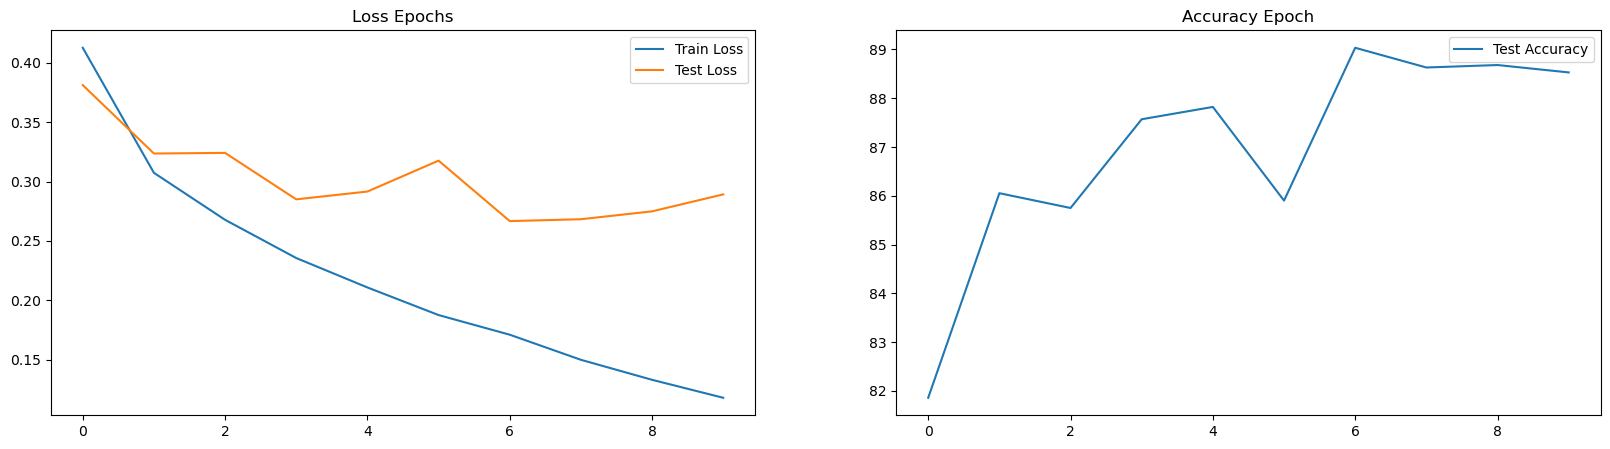

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()

plt.show()  # Don't forget to show the plots!

In [29]:
torch.save(model.state_dict(), "MLP_model.pth")

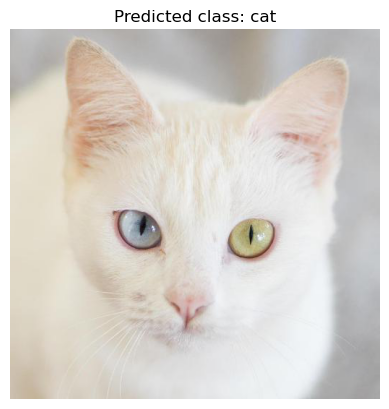

In [57]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = 'data/test/cat/flickr_cat_000016.jpg'

prediction = predict_image(model, image_path)  
class_names = trainset.dataset.classes  

image = Image.open(image_path)

plt.imshow(image)
plt.title(f"Predicted class: {class_names[prediction]}")
plt.axis('off') 
plt.show()

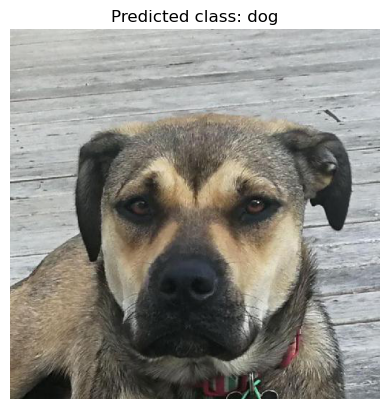

In [59]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = 'data/train/dog/flickr_dog_000008.jpg'

prediction = predict_image(model, image_path)  
class_names = trainset.dataset.classes  

image = Image.open(image_path)

plt.imshow(image)
plt.title(f"Predicted class: {class_names[prediction]}")
plt.axis('off') 
plt.show()